## Introducción al aumento de datos y optimización de modelos

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jeffersonrodriguezc/deep-learning-en-3-semanas/blob/main/semana_3/notebooks/Nb_3c_Introduccion_Aumento_datos_optimizacion.ipynb)

## Resúmen

Este práctica toca los temas de

1. Aumento de datos en problemás de imágenes

  Una técnica para incrementar la diversidad del dataset de entrenamiento aplicando aleatorias pero transformaciones realistas como rotación de imágenes.

  Se revisarán el aumento de datos:

  - Usando las capas de pre-procesamiento como `tf.keras.layers.Resizing`, `tf.keras.layers.Rescaling`, `tf.keras.layers.RandomFlip`, y `tf.keras.layers.RandomRotation`.


2. Optimización de modelos usando Optuna.

  Optuna es una herramienta que permite la optimización hiperparamétrica de modelos usando inferencia Bayesiana.

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

## Descargar el dataset

Se descargarán los datos [tf_flowers](https://www.tensorflow.org/datasets/catalog/tf_flowers). Para conveniencia, descargar el dataset usando [TensorFlow Datasets](https://www.tensorflow.org/datasets).


In [2]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

Nuestro conjunto de entrenamiento tiene diferente tamaño para sus imagenes

In [3]:
for image, label in train_ds.take(5):
  print(image.shape)

(333, 500, 3)
(212, 320, 3)
(240, 320, 3)
(240, 320, 3)
(317, 500, 3)


El dataset tiene 5 clases

In [4]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


Como ejemplo se usará una imágen del dataset para demostrar el aumento de datos

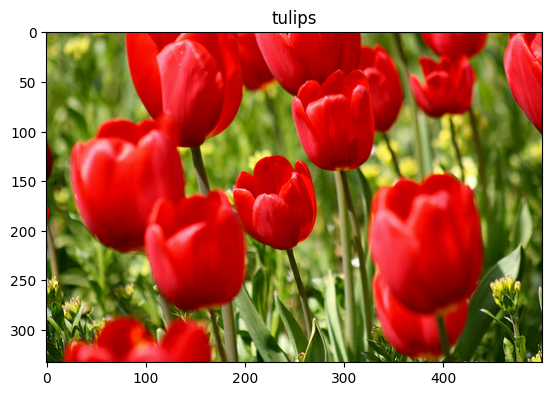

In [5]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

### Capas de pre-procesamiento de Keras

### Redimensionado y re-escalado


Es posible usar las capas de pre-procesamiento de keras para redimensionar las imágenes (con `tf.keras.layers.Resizing`), y para re-escalar los valores de los pixeles (con `tf.keras.layers.Rescaling`).

In [6]:
IMG_SIZE = 180

resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    # tf.keras.layers.Rescaling(1./255)  # actívalo si lo necesitas
], name="preproc")

Nota: El reescalado anterior re-escala las imágenes a el rango: `[0, 1]`.


Visualización para apreciar los resultados

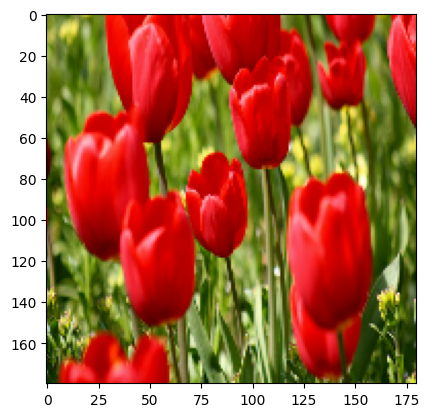

In [7]:
result = resize_and_rescale(image)
_ = plt.imshow(result.numpy().astype("uint8"))

In [8]:
print("Valores min y max de los pixeles:", result.numpy().min(), result.numpy().max())

Valores min y max de los pixeles: 0.0 255.0


### Aumento de datos

Hay otras capas de pre-procesamiento de keras que pueden ser usadas para aumentar datos, por ejemplo: `tf.keras.layers.RandomFlip` y `tf.keras.layers.RandomRotation`.

Vamos a aplicar algunas capas para aplicarlas repetidamente a la misma imágen.

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
], name="augmento")

In [10]:
# Adiccionamos la imágen a un batch
image = tf.cast(tf.expand_dims(result, 0), tf.float32)

In [11]:
image.shape

TensorShape([1, 180, 180, 3])

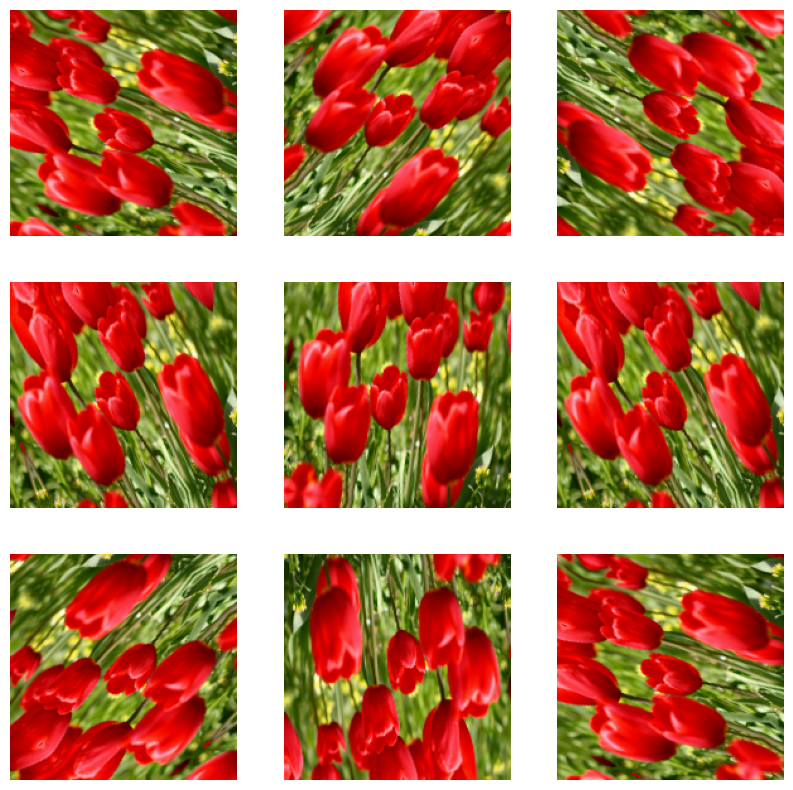

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Hay una variedad de capas de pre-procesamiento para aumento de datos incluyendo `tf.keras.layers.RandomContrast`, `tf.keras.layers.RandomCrop`, `tf.keras.layers.RandomZoom`, y otras. Ver más en https://www.tensorflow.org/guide/keras/preprocessing_layers

### Dos opciones para usar las capas de pre-procesamiento de keras

Hay dos opciones para usar las capas de pre-procesamiento de keras cada una con sus ventajas y desventajas.

#### Opción 1: Incorporar las capas de pre-procesamiento como parte del modelo.

In [13]:
# Hay que definir nuevamente porque las versiones anteriores ya se crearon con
# la dimensión fija de las imágenes al momento de realizar el ejemplo

resize_and_rescale_v2 = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
    # tf.keras.layers.Rescaling(1./255)  # actívalo si lo necesitas
], name="preproc")

data_augmentation_v2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
], name="augmento")

In [14]:
# Vamos a usar el API funcional pero también se puede con el API Secuencial
inputs = tf.keras.Input(shape=(None, None, 3))
x = resize_and_rescale_v2(inputs)
x = data_augmentation_v2(x)
x = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

Hay dos importantes puntos en este caso:

* El aumento de datos correrá paralelamente con los otras partes del modelo beneficiandose del uso de la GPU, esto añade claramente más pasos a la hora de entrenamiento.

* Cuando se exporte el modelo usando `model.save`, las capas de pre-procesamiento se almacenarán con el resto del modelo. Si usted despliega este modelo, las imágenes se estandarizaran automaticamente (acorde a como lo definen las capas). Esto puede beneficiar si no se quiere implementar una lógica aparte en el server para pre-procesar las entradas.

**Nota**: Aumento de datos esta inactivo en test por lo que solo se llamará cuando se haga `Model.fit` (no `Model.evaluate` o `Model.predict`).

| Tipo de capa                        | Ejemplos                                                       | Comportamiento                                                                                                                      |
| ----------------------------------- | -------------------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------- |
| **Determinísticas** (no aleatorias) | `Resizing`, `Rescaling`, `CenterCrop`, `Normalization`         | Aplican siempre, tanto en entrenamiento como en inferencia. No dependen de `training=True/False`.                                   |
| **Estocásticas** (aleatorias)       | `RandomFlip`, `RandomRotation`, `RandomZoom`, `RandomContrast` | Solo aplican su aleatoriedad en entrenamiento (`training=True`). En inferencia reproducen la identidad (devuelven la imagen igual). |


#### Ejemplo: aplicando las capas de pre-procesamiento en el modelo.

In [15]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
BATCH_SIZE = 32
AUTOTUNE   = tf.data.AUTOTUNE

def to_float(image, label):
    # Las capas de Keras aceptan uint8, pero float32 es estándar.
    return tf.cast(image, tf.float32), label

def prepare(ds, shuffle=False):
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(to_float, num_parallel_calls=AUTOTUNE)
    # Clave: permitir HxW variables con padded_batch
    ds = ds.padded_batch(
        BATCH_SIZE,
        padded_shapes=([None, None, 3], [])  # imagen y etiqueta
    )
    return ds.prefetch(AUTOTUNE)

In [17]:
train_ds_1 = prepare(train_ds, shuffle=True)
val_ds_1 = prepare(val_ds)
test_ds_1 = prepare(test_ds)

In [18]:
# entrenar para algunas epocas
epochs=5
history = model_1.fit(
  train_ds_1,
  validation_data=val_ds_1,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 117ms/step - accuracy: 0.2874 - loss: 737.2949 - val_accuracy: 0.3815 - val_loss: 29.3050
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - accuracy: 0.3854 - loss: 22.5133 - val_accuracy: 0.3542 - val_loss: 11.7531
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 85ms/step - accuracy: 0.3906 - loss: 8.7548 - val_accuracy: 0.3951 - val_loss: 7.5477
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.3753 - loss: 5.2572 - val_accuracy: 0.3815 - val_loss: 5.9367
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.3744 - loss: 3.9919 - val_accuracy: 0.3678 - val_loss: 4.5121


In [19]:
loss, acc = model_1.evaluate(test_ds_1)
print("Accuracy", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.3950 - loss: 4.5999
Accuracy 0.3978201746940613


#### Opción 2: Aplicar las capas de pre-procesamiento al dataset

In [20]:
aug_ds = train_ds.map(
  lambda x, y: (resize_and_rescale(x, training=True), y))

Este enfoque usa `Dataset.map` para crear batches de imágenes augmentadas. En este caso:

* El augmento de datos ocurrirá de manera asincróna en la CPU, y es posible sobrelapar el entrenamiento del modelo (usando GPU) con el pre-procesamiento de los datos en CPU.
* En este caso las capas no se exportan con el modelo así que hay que exportarlas o implementar en el server.


#### Ejemplo: aplicando las capas de pre-procesamiento al dataset

Configura los conjuntos de datos de entrenamiento, validación y prueba utilizando las capas de preprocesamiento de Keras que creaste anteriormente.
Además, optimiza el rendimiento de los conjuntos de datos empleando lecturas en paralelo y *buffered prefetching*, para obtener lotes desde el disco sin que las operaciones de entrada/salida (I/O) se conviertan en un cuello de botella.
(Puedes obtener más información sobre cómo mejorar el rendimiento en la guía [Mejor rendimiento con la API `tf.data`](https://www.tensorflow.org/guide/data_performance)).


**Nota**: El aumento de datos solo se aplica al entrenamiento

In [21]:
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
  # Redimensionar y reescalar todo el dataset
  ds = ds.map(lambda x, y: (resize_and_rescale(x), y),
              num_parallel_calls=AUTOTUNE)

  # mezclar las muestras
  if shuffle:
    ds = ds.shuffle(1000)

  # Crear los batches
  ds = ds.batch(batch_size)

  # Usar aumento de datos solo al conjunto de entrenamiento
  if augment:
    ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                num_parallel_calls=AUTOTUNE)

  # Optimizar el buffer para todo el dataset
  return ds.prefetch(buffer_size=AUTOTUNE)

In [22]:
train_ds_2 = prepare(train_ds, shuffle=True, augment=True)
val_ds_2 = prepare(val_ds)
test_ds_2 = prepare(test_ds)

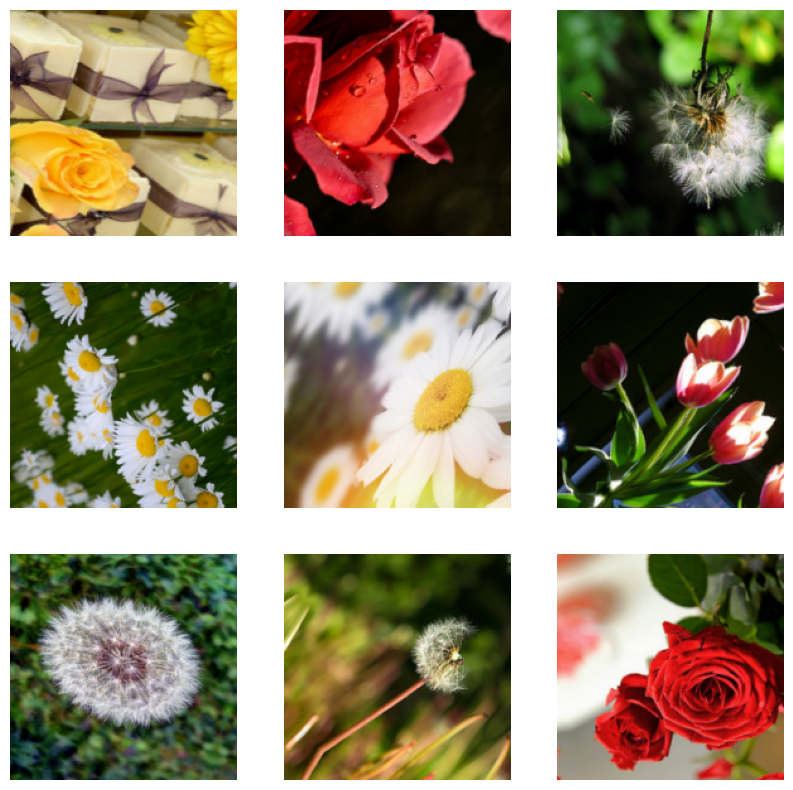

In [23]:
# revisar algunas muestras de train
image_batch, label_batch = next(iter(train_ds_2))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  plt.axis("off")

#### Entrenar el modelo

Para terminar entrenar el modelo usando los datasets:

In [24]:
# usando el API Secuencial, puede ser también el funcional
model_2 = tf.keras.Sequential([
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [25]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
# entrenar para algunas epocas
epochs=5
history = model_2.fit(
  train_ds_2,
  validation_data=val_ds_2,
  epochs=epochs
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.2671 - loss: 113.0121 - val_accuracy: 0.3270 - val_loss: 1.6736
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.4264 - loss: 1.3940 - val_accuracy: 0.3542 - val_loss: 1.6405
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.3603 - loss: 1.4973 - val_accuracy: 0.3597 - val_loss: 1.5463
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.3850 - loss: 1.4291 - val_accuracy: 0.3842 - val_loss: 1.5115
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 0.3930 - loss: 1.3998 - val_accuracy: 0.3597 - val_loss: 1.4502


In [27]:
loss, acc = model_2.evaluate(test_ds_2)
print("Accuracy", acc)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4186 - loss: 1.4236
Accuracy 0.40326976776123047


### Aumento de datos personalizado

Para crear capas personalizadas de aumento de datos en caso de que no esten
implementadas.

Dos pasos para hacerlo:

- Primer, crear una capa `tf.keras.layers.Lambda`. Recomendado.
- Luego, escribir una nueva capa via [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models), lo cual ya es sabido que proporciona más control.

Ejemplo invirtiendo los colores de una imágen aleatoriamente.

In [28]:
def random_invert_img(x, p=0.5):
  if  tf.random.uniform([]) < p:
    x = (255-x)
  else:
    x
  return x

In [29]:
def random_invert(factor=0.5):
  return tf.keras.layers.Lambda(lambda x: random_invert_img(x, factor))

random_invert = random_invert()

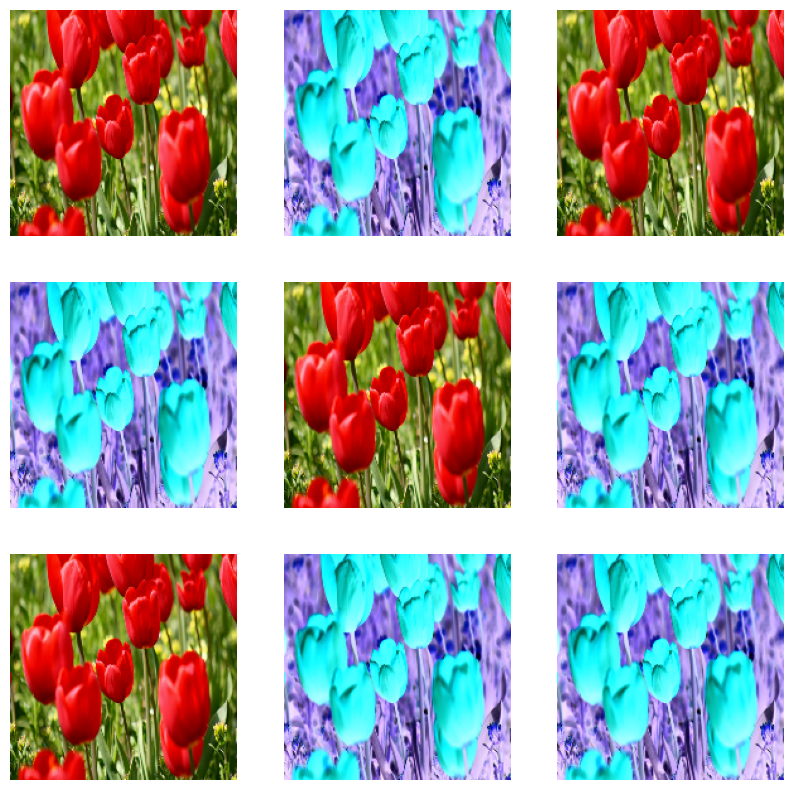

In [30]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = random_invert(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0].numpy().astype("uint8"))
  plt.axis("off")

Implementar una capa custom usando [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models):

In [31]:
class RandomInvert(tf.keras.layers.Layer):
  def __init__(self, factor=0.5, **kwargs):
    super().__init__(**kwargs)
    self.factor = factor

  def call(self, x):
    return random_invert_img(x)

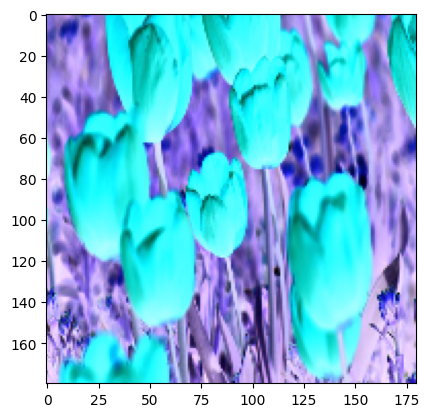

In [32]:
_ = plt.imshow(RandomInvert()(image)[0].numpy().astype("uint8"))

Estas capas pueden ser usadas en las opciones 1 y 2 vistas anteriormente.

## Optimización de hiperparámetros usando Optuna

In [35]:
!pip install optuna
!pip install optuna-integration[tfkeras]

import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 4.8 MB/s eta 0:00:00


1. Crear el modelo con las opciones de optuna

In [53]:
def create_model(trial):
    # creamos los valores sugeridos para cada hp que se desea evaluar
    n_layers = trial.suggest_int('n_layers', 1, 3)
    dropout_rate = trial.suggest_float("dropout", 0.0, 0.3)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])


    model = tf.keras.Sequential()
    for i in range(n_layers):
        num_filters = trial.suggest_int(f'n_filters_l{i}', 32, 64, log=True)
        model.add(tf.keras.layers.Conv2D(num_filters, 3, activation=activation))
        model.add(tf.keras.layers.MaxPooling2D())

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                  metrics=['accuracy'])

    return model

2. Ahora definir una función objetivo a ser maximizada

In [55]:
EPOCHS = 5 # Número de epocas para cada trial

def objective(trial):

    # Limpiar cada grafo
    tf.keras.backend.clear_session()

    model = create_model(trial)

    # Entrenar el modelo y validarlo
    model.fit(
        train_ds_2,
        callbacks=[TFKerasPruningCallback(trial, "val_accuracy")],
        epochs=EPOCHS,
        validation_data=val_ds_2,
        verbose=1,
    )

    # evaluar el modelo en test
    score = model.evaluate(test_ds_2, verbose=0)
    return score[1]

3. Instanciar y hacer la optimización

In [ ]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.HyperbandPruner())
study.optimize(objective, n_trials=20)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2025-08-11 14:21:34,560] A new study created in memory with name: no-name-2fa5eeb1-4d2b-493a-bb10-b101b6a03d88


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 169ms/step - accuracy: 0.3103 - loss: 1024.8566 - val_accuracy: 0.2779 - val_loss: 2.1518
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.2390 - loss: 1.8287 - val_accuracy: 0.2425 - val_loss: 1.7280
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 132ms/step - accuracy: 0.2537 - loss: 1.6687 - val_accuracy: 0.2616 - val_loss: 1.8796
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 136ms/step - accuracy: 0.2734 - loss: 1.6455 - val_accuracy: 0.2398 - val_loss: 1.6109
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.2477 - loss: 1.6010 - val_accuracy: 0.2398 - val_loss: 1.6557


[I 2025-08-11 14:23:16,690] Trial 0 finished with value: 0.19073569774627686 and parameters: {'n_layers': 1, 'dropout': 0.16859144182096772, 'activation': 'relu', 'n_filters_l0': 33}. Best is trial 0 with value: 0.19073569774627686.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 201ms/step - accuracy: 0.2562 - loss: 296.6700 - val_accuracy: 0.3569 - val_loss: 1.5277
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 138ms/step - accuracy: 0.3992 - loss: 1.4691 - val_accuracy: 0.3706 - val_loss: 1.5133
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - accuracy: 0.4424 - loss: 1.3652 - val_accuracy: 0.3678 - val_loss: 1.4495
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.4578 - loss: 1.3083 - val_accuracy: 0.4469 - val_loss: 1.3432
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 138ms/step - accuracy: 0.4557 - loss: 1.3086 - val_accuracy: 0.4578 - val_loss: 1.3263


[I 2025-08-11 14:25:21,886] Trial 1 finished with value: 0.40326976776123047 and parameters: {'n_layers': 2, 'dropout': 0.16115710096047375, 'activation': 'relu', 'n_filters_l0': 41, 'n_filters_l1': 43}. Best is trial 1 with value: 0.40326976776123047.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 177ms/step - accuracy: 0.2532 - loss: 18.2350 - val_accuracy: 0.2425 - val_loss: 1.6078
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.2642 - loss: 1.6067 - val_accuracy: 0.2425 - val_loss: 1.6046
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 142ms/step - accuracy: 0.2570 - loss: 1.6041 - val_accuracy: 0.2425 - val_loss: 1.6018
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 139ms/step - accuracy: 0.2454 - loss: 1.6048 - val_accuracy: 0.2425 - val_loss: 1.5998
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - accuracy: 0.2564 - loss: 1.6012 - val_accuracy: 0.2425 - val_loss: 1.5981


[I 2025-08-11 14:26:52,435] Trial 2 finished with value: 0.19073569774627686 and parameters: {'n_layers': 2, 'dropout': 0.20937211907599296, 'activation': 'tanh', 'n_filters_l0': 35, 'n_filters_l1': 55}. Best is trial 1 with value: 0.40326976776123047.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.2502 - loss: 45.9957 - val_accuracy: 0.2561 - val_loss: 1.6004
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2862 - loss: 1.6000

[I 2025-08-11 14:27:31,315] Trial 3 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 178ms/step - accuracy: 0.2180 - loss: 2721.4155 - val_accuracy: 0.1744 - val_loss: 3.5069
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step - accuracy: 0.2152 - loss: 2.1417 - val_accuracy: 0.2425 - val_loss: 1.6058
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.2406 - loss: 1.6666 - val_accuracy: 0.2425 - val_loss: 1.6031
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.2586 - loss: 1.6143 - val_accuracy: 0.2425 - val_loss: 1.6010
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.2565 - loss: 1.6054 - val_accuracy: 0.2425 - val_loss: 1.5990


[I 2025-08-11 14:28:45,048] Trial 4 finished with value: 0.19073569774627686 and parameters: {'n_layers': 1, 'dropout': 0.11874098770505685, 'activation': 'relu', 'n_filters_l0': 32}. Best is trial 1 with value: 0.40326976776123047.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 202ms/step - accuracy: 0.2455 - loss: 62.7376 - val_accuracy: 0.2534 - val_loss: 1.5811
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2904 - loss: 1.5872

[I 2025-08-11 14:29:41,941] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.2809 - loss: 12.5328 - val_accuracy: 0.2507 - val_loss: 1.5977
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 141ms/step - accuracy: 0.2621 - loss: 1.5902 - val_accuracy: 0.2997 - val_loss: 1.5463
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - accuracy: 0.2680 - loss: 1.5886 - val_accuracy: 0.2616 - val_loss: 1.5766
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 140ms/step - accuracy: 0.2938 - loss: 1.5563 - val_accuracy: 0.2752 - val_loss: 1.5263
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.2968 - loss: 1.5329 - val_accuracy: 0.2561 - val_loss: 1.5749


[I 2025-08-11 14:31:02,682] Trial 6 finished with value: 0.19618529081344604 and parameters: {'n_layers': 3, 'dropout': 0.26487988121739164, 'activation': 'relu', 'n_filters_l0': 53, 'n_filters_l1': 41, 'n_filters_l2': 32}. Best is trial 1 with value: 0.40326976776123047.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.2948 - loss: 1855.7390 - val_accuracy: 0.4414 - val_loss: 3.8743
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - accuracy: 0.3865 - loss: 4.0972 - val_accuracy: 0.4251 - val_loss: 2.5967
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 138ms/step - accuracy: 0.3883 - loss: 1.8732 - val_accuracy: 0.3896 - val_loss: 1.6159
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3690 - loss: 1.5267

[I 2025-08-11 14:32:05,096] Trial 7 pruned. Trial was pruned at epoch 3.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 197ms/step - accuracy: 0.2681 - loss: 292.4881 - val_accuracy: 0.2507 - val_loss: 1.5989
Epoch 2/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2816 - loss: 1.5845

[I 2025-08-11 14:33:02,142] Trial 8 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 25s 203ms/step - accuracy: 0.2414 - loss: 3.2658 - val_accuracy: 0.2507 - val_loss: 1.6025
Epoch 2/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2667 - loss: 1.6032

[I 2025-08-11 14:34:05,337] Trial 9 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 178ms/step - accuracy: 0.2390 - loss: 8.9080 - val_accuracy: 0.2507 - val_loss: 1.6022
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2583 - loss: 1.6020

[I 2025-08-11 14:34:41,124] Trial 10 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.2577 - loss: 119.4626 - val_accuracy: 0.3188 - val_loss: 1.5606
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3315 - loss: 1.5621

[I 2025-08-11 14:35:25,392] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 31s 243ms/step - accuracy: 0.2491 - loss: 23.4778 - val_accuracy: 0.2561 - val_loss: 1.5940
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2735 - loss: 1.6005

[I 2025-08-11 14:36:29,267] Trial 12 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.2405 - loss: 143.2521 - val_accuracy: 0.2807 - val_loss: 1.5992
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2880 - loss: 1.6023

[I 2025-08-11 14:37:26,690] Trial 13 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 195ms/step - accuracy: 0.2600 - loss: 3.5397 - val_accuracy: 0.3079 - val_loss: 1.5615
Epoch 2/5
91/92 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3587 - loss: 1.5019

[I 2025-08-11 14:38:29,365] Trial 14 pruned. Trial was pruned at epoch 1.


Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 24s 193ms/step - accuracy: 0.2430 - loss: 122.1453 - val_accuracy: 0.2997 - val_loss: 1.5770
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 32s 139ms/step - accuracy: 0.2892 - loss: 1.5852 - val_accuracy: 0.2779 - val_loss: 1.5682
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 139ms/step - accuracy: 0.3138 - loss: 1.5644 - val_accuracy: 0.3079 - val_loss: 1.5429
Epoch 4/5


#### Visualización de resultados

In [62]:
plot_optimization_history(study)

In [63]:
plot_intermediate_values(study)

In [64]:
plot_contour(study)

[W 2025-08-11 14:55:09,141] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,142] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,143] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,144] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,145] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,146] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,147] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,148] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,148] Param n_filters_l2 unique value length is less than 2.
[W 2025-08-11 14:55:09,149] Param n_filters_l2 unique value length is less than 2.


In [65]:
plot_param_importances(study)

In [66]:
print("Estadísticas: ")
print(" Número de trials realizados: ", len(study.trials))
print("  Número de pruned trials: ", len(pruned_trials))
print("  Número de trials completos: ", len(complete_trials))

print("Mejor trial:")
trial = study.best_trial

print("  Valor: ", trial.value)

print("  Parámetros: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Estadísticas: 
 Número de trials realizados:  20
  Número de pruned trials:  13
  Número de trials completos:  7
Mejor trial:
  Valor:  0.40326976776123047
  Parámetros: 
    n_layers: 2
    dropout: 0.16115710096047375
    activation: relu
    n_filters_l0: 41
    n_filters_l1: 43
